# MosAIc 

## Einführung

Wir sind Henning Sander, Jannik Wübbe und Fynn Ellinghaus aus der MosAIc-Gruppe des Modules Medienverarbeitung 21/22. In dem folgenden Dokument erhalten Sie einen detaillierten Einblick über unser Projekt.
Es war unser Ziel eine Software zu erstellen, die aus einer beliebigen Videodatei bzw. Bildergalerie automatisiert ein Mosaik aus einer Bildvorlage erstellen kann. 
Unsere Idee war es eine Videodatei wie z.B. eine Computerspielaufnahme oder auch eine Aufnahme einer Festivität in die Software einlesen zu können. Diese kreiert aus dieser mittels Frames (Standbilder), eine Bildbibliothek. Diese kann im Nachfolgenden durch ein eingelesenes Bild genutzt werden, welches als Schablone dient, ein Mosaik automatisiert zu erstellen.
Wir hoffen Sie werden Freude beim Lesen haben.

## Ersten Schritte

### Ein Anfang muss gemacht werden

In den ersten Schritten war unsere Idee erst einmal anzufangen und die Grundfunktionen des Programmes zu erstellen. Hierzu haben wir zunächst eine Funktion erstellt, die es uns ermöglicht Bilder in Python zu importieren. Weil in OpenCV (Python-Bibliothek) der Farbwert mit BGR (blue/green/red) angegeben wird und wir verhindern wollten, dass sich dadurch Fehler ergeben, haben wir eine Konvertierung eingebaut, die BGR auf RGB (red/green/blue) umschreibt.

In [2]:
import cv2
import matplotlib.pyplot as plt
import math
import os
import numpy as np
import matplotlib

matplotlib.rcParams['figure.figsize'] = [12, 12]
matplotlib.rcParams['figure.dpi'] = 72

#Bild importieren mit RGB Konvertierung
def rgbImport(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Unsere nächste Intention war es, ein Bild quadratisch zuzuschneiden. Weil ein Pixel ebenfalls quadratisch ist und die von uns genutzten Bilder im 16:9 Format waren, wollten wir diese zuschneiden, um es später einfacher zu haben, die Pixel durch die Bilder zu ersetzen.
Als erstes haben wir mit festen Breiten- (width) und Höhen- (hight) Werten gearbeitet. Mit der mathplotlib-Bibliothek haben wir uns eine Ausgabe erschaffen, damit wir direkt die Resultate sehen können. Weil uns aber bewusst war, dass wir nicht nur mit 1920x1080 Bildern arbeiten werden, haben wir die Funktion verallgemeinert.
Das Bild wird im letzten Schritt testweise quadratisch zugeschnitten und in 256x256 ausgegeben und angezeigt.

In [8]:
#Beliebiges Bild quadratisch zuschneiden
def quadsizeFix(img):

    height, width, channels = img.shape

    if width > height :
        wStart = int((width - height)/2)
        wEnd = wStart + height
        cropped_image = img[:, wStart:wEnd]
    else :
        hStart = int((height - width)/2)
        hEnd = hStart + width
        cropped_image = img[hStart:hEnd, :]
        
    
    return cv2.resize(cropped_image,(256,256))

img = rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png")
quadImg = quadsize(img)
        
plt.imshow(quadImg)

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Nach späteren Überlegungen, haben wir uns dazu entschlossen, die Methode dynamisch zu gestalten, da wir dem Nutzer die Möglichkeit geben wollen, Einfluss auf die Auflösung des Bildes zu nehmen.

In [ ]:
# Beliebiges Bild quadratisch zuschneiden
def quadsize(img, size):
    height, width, channels = img.shape

    if width > height:
        wStart = int((width - height) / 2)
        wEnd = wStart + height
        cropped_image = img[:, wStart:wEnd]
    else:
        hStart = int((height - width) / 2)
        hEnd = hStart + width
        cropped_image = img[hStart:hEnd, :]

    return cv2.resize(cropped_image, (size, size))

Der folgende Ansatz war es, dass das Bild verpixelt wird, um eine kleinere Detaildichte zu erreichen.
Hierzu wurde die dynamische Verpixelung genutzt.
Mit dieser Methode wird jedes Bild welches eingelesen wird um den Faktor 12 komprimiert.
Unsere Idee war es dadurch den Farbwert besser bestimmen zu können und Ressourcen zu sparen.

In [ ]:
#Komprimierungsansatz mittels dynamischer Verpixelung
def destroyImgDyn(img):
    height, width, channels = img.shape
    img = cv2.resize(img,(int(width/12),int(height/12)))
    return img

toDestroyImg = rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png")
plt.imshow(destroyImgDyn(toDestroyImg))

Um es zu vereinfachen, haben wir eine fast gleiche Methode geschrieben, welche das Bild auf die feste Größe von 128x72 komprimiert. 

In [ ]:
#Komprimierungsansatz auf feste Größe (TODO: auch Hochkanntbilder sollen unterstützt werden)
def destroyImgFix(img):
    img = cv2.resize(img,(128,72))
    return img

plt.imshow(destroyImgFix(toDestroyImg))

Da durch destroyImgDyn() die Auflösung des Originalbildes Einfluss auf die Größe des Mosaiks hat und
destroyImgFix() ein einheitliches Seitenverhältnis voraussetzt haben wir uns für die folgende Lösung entschieden.

Dieser Methode werden Parameter zur Breite und Höhe übergeben, welche anschließend verwendet werden, das Bild zu skalieren.
Abschließend wird das skalierte Bild zurückgegeben.

In [ ]:
# Komprimierungsansatz auf feste Größe
def destroyImg(img, width, height):
    img = cv2.resize(img, (width, height))
    return img

Der nächste Schritt war es von einem Bild den durschschnittlichen Farbwert zu bestimmen. Dieses soll uns später die Möglichkeit geben Farbwerte zu vergleichen. 
Hierzu wurde die folgende Methode geschrieben. Der Gedanke war, das Bild auf eine Größe von 1x1 Pixel zuzuschneiden, um dadurch den mittleren Farbwert zu erhalten.
Dies entpuppte sich als ein Fehler, weil es uns dadurch einen verfälschten Wert für uns geliefert hat. So wurden beispielsweise Bereiche in einem Bild dunkel dargestellt, obwohl diese eigentlich hell sein müssten.
Diese Methode wurde durch die getColorValue-Methode ersetzt.

In [ ]:
#Methode, die den durschnittlichen Farbwert eines Bildes liefert
def getColorValueWRONG(img):
    img = cv2.resize(img, (1,1))
    return img[0][0]

getColorValueWRONG(img)

In der getColorValue Methode ermitteln wir den durschnittlichen Farbwert.

In [ ]:
#Methode, die den durschnittlichen Farbwert eines Bildes liefert
def getColorValue(img):
    return img.mean(axis=0).mean(axis=0)

getColorValue(img)

Mit den vorhandenen Methoden ist es uns möglich die Farbwerte zu bestimmen und im nächsten Schritt sollen zwei Farbwerte miteinander verglichen werden können. Hierzu nutzen wir die Euklidische Distanz im dreidiminsionalen Raum:

$$d(p,q) = \sqrt{(q1 - p1)^2 + (q2 - p2)^2 + (q3 - p3)^2} = \sqrt {\sum \limits _{i=1} ^{n=3}(qi - pi)^2}$$

Der Sinn dieser Methoden ist es, den Farbwert eines Pixels zu bestimmen und diesen mit dem mittleren Farbwert eines Bildes vergleichen zu können.
Dies ermöglicht es uns ein Bild zu finden, dessen durchschnittlicher Farbwert dem Farbwert des Pixels am meisten ähnelt, um später diesen Pixel durch das Bild zu ersetzen.
Wenn dies für jeden Pixel durchgeführt wird, sollte am Ende ein Mosaik entstehen, welches sehr ähnliche Farbwerte aufweist und das Schablonenbild sehr nah imitert.

In [ ]:
#Euklidische Distanz berechen (Farbunterschied)
def getColorDifference(color1, color2):
    return math.sqrt((int(color1[0])- int(color2[0]))**2+(int(color1[1]) - int(color2[1]))**2+(int(color1[2])- int(color2[2]))**2)

getColorDifference(getColorValue(img),getColorValue(toDestroyImg))

Weil ein Mosaik nicht nur aus einem Bild sondern aus vielen besteht, haben wir uns ein Programm gesucht, welches uns aus einer Videodatei eine Bilderbibliothek erstellen kann. Dieses heißt ffmpeg und kann fast alle gängigen Videoformate lesen und bearbeiten. Es wird über die Eingabeaufforderung gestartet.
Mit den folgenden Parametern lesen wir die Videodatei und erhalten einzelne Bilder.

                ffmpeg -i video.mp4 -vf fps=1/5 bib/out%d.jpeg
        
ffmpeg startet das Programm. Danach wird der Dateipfad der Videodatei angegeben (in unserem Fall in dem Ordner des Programms selbst). Mit -vf wird dem Programm mitgeteilt, dass wir Videoframes haben wollen und mit den fps geben wir an, dass wir alle fünf Sekunden ein Frame (Bild) haben wollen. Zuletzt geben wir den Ausgabeordner (bib) an und den Namen sowie das Dateiformat (jpeg), den das Bild haben soll. Mit %d werden die Bilder automatisch durchnummeriert.

Anfangs haben wir selbst aufgenommene Videodateien aus dem Videospiel "Hunt: Showdown" genutzt. Hier wird später noch näher drauf eingegangen. 

Mit der getAllImages Methode, werden alle Bilder aus der Bilderbibliothek in ein Array geladen. Uns wird zur Bestätigung die Länge des Arrays (Anzahl der Bilder) und ein Beispielbild ausgegeben.

In [ ]:
#Funktion, die Bilder importiert
def getAllImages(folderPath):
    images = []
    for filename in os.listdir(folderPath):
        img = rgbImport(os.path.join(folderPath, filename))
        if img is not None:
            images.append(img)
    return images
    
allImages = getAllImages("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/out")
print(len(allImages))
plt.imshow(allImages[0])

Jetzt werden mit cropAllImages alle Bilder zugeschnitten. Dies geschrieht mit der quadsize Methode vom Anfang.

In [ ]:
#Schneidet alle Bilder zu
def cropAllImages(allImages):
    allCroppedImages = []
    for img in allImages:
        allCroppedImages.append(quadsize(img))
    return allCroppedImages

plt.imshow(cropAllImages(allImages)[1])

Weiter werden alle Farbwerte der einzenen Bilder bestimmt und in dem allColorValues Array abgespeichert.

In [ ]:
#Ermittelt die durchschnittlichen Farbwerte aller Bilder
def getAllColorValues(allImages):
    allColorValues = []
    for img in allImages:
        allColorValues.append(getColorValue(img))
    return allColorValues

getAllColorValues(allImages)[1]

Es ist an der Zeit alles zusammenzuführen. In der createMosaic Methode wird zunächst mit dem originImg das Bild, welches als Schablone dienen soll, mit der destroyImgFix in die gewünschte Verpixelung und Größe gebracht.
Dann werden Höhe, Breite und die Kanäle ausgelesen.
Nun wird das Bild zeilenweise durchlaufen und für jeden Pixel des ogriginImg (der Schablone) werden die Farbwerte mit denen in dem allColorValues Array verglichen, um den Farbwert mit dem geringsten Abstand zu finden. Wenn der minimalste Abstand gefunden wurde, wird das Bild aus dem Array allCroppedImages an der Position des Farbwertes angehangen. Dies wird konkatenierend durchgeführt, bis das gesamte Bild durchlaufen wurde.

In [ ]:
#Erstellt das MosAIc
def createMosaic(originImg, allCroppedImages, allColorValues):
    originImg = destroyImgFix(originImg)
    height, width, channels = originImg.shape
    col = []
    for y in range(height):
        row = []
        for x in range(width):
            minDif = 500
            for i in range(len(allColorValues)):
                value = allColorValues[i]
                dif = getColorDifference(value, originImg[y,x])
                if dif < minDif:
                    minDif = dif
                    minDifPosition = i
            row.append(allCroppedImages[minDifPosition])
        col.append(np.concatenate(row, axis = 1))
    return cv2.cvtColor(np.concatenate(col, axis = 0), cv2.COLOR_BGR2RGB)
    
    #Henning: "Ich würde sagen, das sieht gut aus."

images = getAllImages("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/out")

mosaic = createMosaic(rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png"), cropAllImages(images), getAllColorValues(images))
cv2.imwrite("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/output.jpeg", mosaic)
#plt.imshow(mosaic)
            

Der erste Versuch ist fehlgeschlagen, weil wir falsche Werte genutzt hatten und Bilder mit 1080x1080 aneinander zu hängen. Dies hat den Arbeitsspeicher eines PC's in die Knie gezwungen, nachdem eine Dateigröße von 7,81GB erschaffen wurde und der Prozess noch nicht beendet war.
Nach diesem Fehler wurden kleiner Werte für die destroyImgFix Methode gewählt.

Allerdings bestanden etwaige Probleme auch nach Anpassung der Größe, was uns veranlasste, eine Datenbank zu implentieren.

## Datenbank
Henning wollte sich setzen, aber nicht ohne seine Daten!

In [ ]:
import os
import sqlite3

import cv2
import numpy as np
from PyQt5.QtWidgets import QApplication

import mosaic


class Database:
    db_path = "mosaic.db"

    def __init__(self):

        self.connection = sqlite3.connect(self.db_path)

        cursor = self.newCursor()
        cursor.execute('''CREATE TABLE IF NOT EXISTS image (
                            image_id INTEGER PRIMARY KEY AUTOINCREMENT,
                            img_original TEXT,
                            img_cropped_32 TEXT,
                            img_cropped_64 TEXT,
                            img_cropped_128 TEXT,
                            img_cropped_256 TEXT,
                            color_r REAL,
                            color_g REAL,
                            color_b REAL);''')
        self.connection.commit()

    def __del__(self):
        self.connection.close()

    def saveImg(self, img_original, img_cropped_32, img_cropped_64, img_cropped_128, img_cropped_256, color, cursor):
        cursor.execute('''INSERT INTO image (img_original, img_cropped_32, img_cropped_64, img_cropped_128, img_cropped_256, color_r, color_g, color_b)
                                VALUES (?,?,?,?,?,?,?,?)''',
                       (self.encode(img_original), self.encode(img_cropped_32), self.encode(img_cropped_64),
                        self.encode(img_cropped_128), self.encode(img_cropped_256), color[0], color[1], color[2]))

    def importAllImages(self, folderPath, progressBar):
        cursor = self.newCursor()
        listdir = os.listdir(folderPath)
        progressBar.setMaximum(len(listdir))
        img_counter = 0
        progressBar.setValue(img_counter)
        progressBar.setVisible(True)
        QApplication.processEvents()

        for filename in listdir:
            img = mosaic.rgbImport(os.path.join(folderPath, filename))
            if img is not None:
                self.saveImg(img,
                             mosaic.quadsize(img, 32),
                             mosaic.quadsize(img, 64),
                             mosaic.quadsize(img, 128),
                             mosaic.quadsize(img, 256),
                             mosaic.getColorValue(img),
                             cursor)
            img_counter += 1
            progressBar.setValue(img_counter)
            QApplication.processEvents()
        cursor.connection.commit()

    def getAllCroppedImages(self):
        cursor = self.newCursor()
        cursor.execute('''SELECT img_cropped_32 FROM image''')
        return cursor

    def getCroppedImagesWithIDByID(self, ids, elementSize):
        cursor = self.newCursor()
        if elementSize == "32":
            sql = "SELECT image_id, img_cropped_32 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        elif elementSize == 64:
            sql = "SELECT image_id, img_cropped_64 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        elif elementSize == 128:
            sql = "SELECT image_id, img_cropped_128 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        else:
            sql = "SELECT image_id, img_cropped_256 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))

        cursor.execute(sql, ids)
        return cursor

    def getAllOriginalImages(self):
        cursor = self.newCursor()
        cursor.execute('''SELECT img_original FROM image''')
        return cursor

    def getAllColorValuesWithIDs(self):
        cursor = self.newCursor()
        cursor.execute('''SELECT image_id, color_r, color_g, color_b FROM image''')
        return cursor

    def newCursor(self):
        return self.connection.cursor()

    def encode(self, img):
        img_encode = cv2.imencode('.png', img)[1]
        data_encode = np.array(img_encode)
        return data_encode.tostring()

    def decode(self, img_string):
        nparr = np.fromstring(img_string, np.uint8)
        return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    def deleteLibrary(self):
        cursor = self.newCursor()
        cursor.execute('''DELETE FROM image''')
        self.connection.commit()


## GUI

Angesichts Bedienbarkeit und dem Experimentieren mit verschiedensten Werten haben wir uns dazu entschlossen,
eine GUI mithilfe von QT-Designer zu erstellen.
Mit dem Befehl "pyuic5 -o ui/Ui_MainWindow.py main_window.ui" wurde die .UI-Datei in Python-Code umgewandelt.
Näheres dazu lässt sich im Anhang wiederfinden.

# Ergebnisse

## Erste Erkenntnisse
Wie zuvor schon erwähnt, nutzten wir Bilder des Videospiels "Hunt: Showdown". Nach vielen Tests ist uns klar geworden, dass sich dieses Spiel nicht gut eignet, weil dieses vorwiegend in dunklen und entsättigten Farben/Farbtönen gehalten ist und somit keine große Referenzmenge an Farbwerten darstellen kann.
Dadurch ist es schwierig, kräftige Farben sowie starke Farbkontraste darzustellen.
Aus diesem Grund haben wir uns vorgenommen, zu einem anderen Spiel zu wechseln, das ein breiteres Farbspektrum abdeckt.
Es wurden noch weitere Bilder getestet wie z.B Hundebilder, Naturbilder und Gesichter.
Uns ist schnell klar geworden, dass es einfacher ist Gesichter darzustellen.
Wir vermuten, dass das menschliche Gehirn evolutionär darauf geeicht ist diese schnell zu erfassen.

In [ ]:
#Größter Farbwertunterschied
getColorDifference([255,255,255],[0,0,0])


## Gesichtserkennung
Stock-Fotos von https://www.pexels.com/

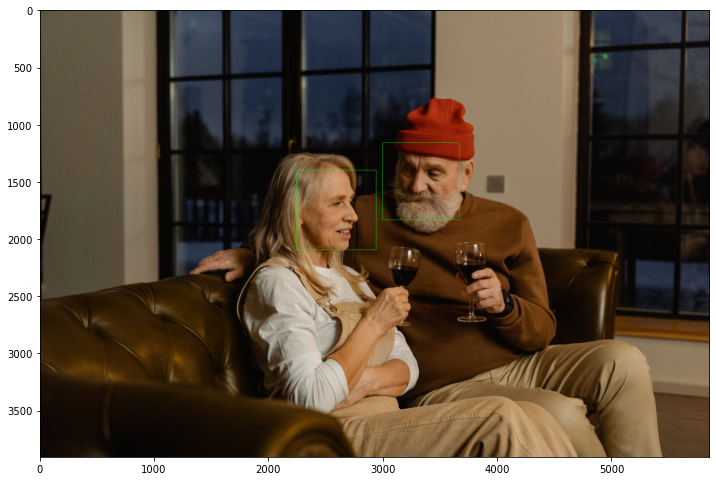

In [9]:
img = rgbImport("bib_stock_faces/pexels-mart-production-7328509.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img_gray, minNeighbors=15)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(img)

In [4]:
def get_faces(img, min_neighbors):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    return face_cascade.detectMultiScale(img_gray, minNeighbors=min_neighbors)

In [ ]:
# Beliebiges Bild quadratisch zuschneiden
def quadsize(img, size, crop_to_faces, min_neighbors):
    if crop_to_faces:
        faces = get_faces(img, min_neighbors)
        if len(faces) == 0:
            return quadsize_centered(img, size)

        face_centers = []
        for (x, y, w, h) in faces:
            face_centers.append([x + (w / 2), y + (h / 2)])

        face_centers = np.asarray(face_centers)
        crop_center = np.mean(face_centers, axis=0)
        return quadsize_centered_on_point(img, size, crop_center)

    else:
        return quadsize_centered(img, size)

In [ ]:
def quadsize_centered(img, size):
    height, width, channels = img.shape
    return quadsize_centered_on_point(img, size, [width / 2, height / 2])

In [ ]:
def quadsize_centered_on_point(img, size, center):
    height, width, channels = img.shape

    if width > height:
        w_start = int(center[0] - (height/2))
        if w_start < 0:
            w_start = 0

        w_end = w_start + height
        if w_end > width:
            w_start = width - height
            w_end = width

        cropped_image = img[:, w_start:w_end]
    else:
        h_start = int(center[1] - (width/2))
        if h_start < 0:
            h_start = 0

        h_end = h_start + width
        if h_end > height:
            h_start = height - width
            h_end = height

        cropped_image = img[h_start:h_end, :]

    return cv2.resize(cropped_image, (size, size))

## Kantenerkennung

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

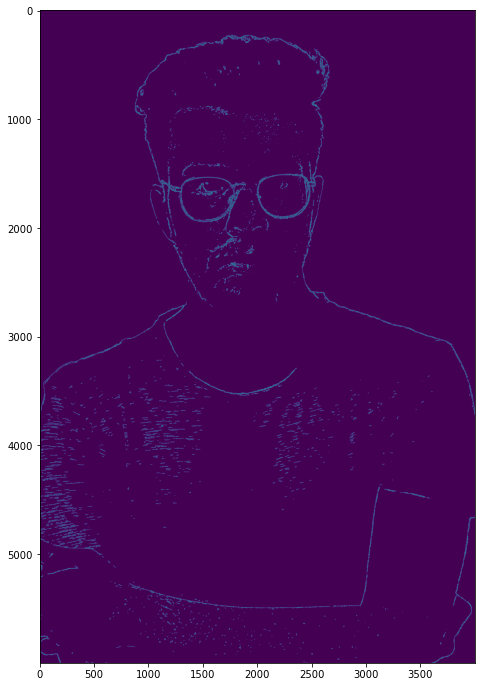

In [7]:
# img = rgbImport("bib_stock_faces/pexels-mart-production-7328509.jpg")
# img = rgbImport("bib_stock_faces/pexels-grisha-chernigowsky-2120114.jpg")
img = rgbImport("bib_stock_faces/pexels-nitin-khajotia-1516680.jpg")
# img = rgbImport("D:/Projekt/Uni/Medienverarbeitung/res/out/1069.png")


detected_edges = cv2.Canny(img.astype(np.uint8), 100, 250)

# faces = get_faces(img,5)
# for (x, y, w, h) in faces:
#     cv2.rectangle(detected_edges, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(detected_edges)
detected_edges

## Anhang

#### Window.py

In [ ]:
import shutil
import subprocess
import sys

from PyQt5 import QtGui
from PyQt5.QtWidgets import QMainWindow

from Database import Database
from mosaic import *
from ui.Ui_MainWindow import Ui_MainWindow


# pyuic5 -o ui/Ui_MainWindow.py main_window.ui
class Window(QMainWindow, Ui_MainWindow):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.setupUi(self)

        # tab-buttons
        self.libraryTabButton.clicked.connect(self.bibTabBtnListiner)
        self.classicTabButton.clicked.connect(self.classicTabBtnListiner)
        self.partialTabButton.clicked.connect(self.partialTabBtnListiner)

        # library-page
        self.imageListViewModel = QtGui.QStandardItemModel()
        self.imageListView.setModel(self.imageListViewModel)

        self.importProgressBar.setVisible(False)

        self.importButton.clicked.connect(self.importBtnListener)
        self.deleteLibraryButton.clicked.connect(self.deleteLibraryBtnListiner)

        # classic-page
        self.classicButton.clicked.connect(self.classicBtnListener)

        self.keepAspectRatioCheckBox.clicked.connect(self.keepAspectRatioCheckBoxBtnListiner)

        self.mosaicHeightLineEdit.setVisible(not self.keepAspectRatioCheckBox.isChecked())
        self.mosaicHeightLabel.setVisible(not self.keepAspectRatioCheckBox.isChecked())

        self.classicProgressBar.setVisible(False)

        # misc
        self.db = Database()

        self.showImageLibrary()

# tab-buttons
    def bibTabBtnListiner(self):
        self.stackedWidget.setCurrentIndex(0)

    def classicTabBtnListiner(self):
        self.stackedWidget.setCurrentIndex(1)

    def partialTabBtnListiner(self):
        self.stackedWidget.setCurrentIndex(2)

# library page
    def importBtnListener(self):
        importPath = self.libraryLineEdit.text()

        if importPath.endswith('.mp4'):
            if os.path.exists('bib'):
                shutil.rmtree('bib')
            os.makedirs('bib')

            subprocess.run('ffmpeg -i ' + importPath + ' -vf fps=1/5 bib/out%d.png')
            self.db.importAllImages('bib', self.importProgressBar)

        else:
            self.db.importAllImages(importPath, self.importProgressBar)

        self.showImageLibrary()

    def deleteLibraryBtnListiner(self):
        self.db.deleteLibrary()
        self.imageListViewModel.removeRows(0, self.imageListViewModel.rowCount())

    def showImageLibrary(self):
        self.imageListViewModel.removeRows(0, self.imageListViewModel.rowCount())
        cursor = self.db.getAllCroppedImages()
        for img_arr in cursor:
            img = self.db.decode(img_arr[0])

            image = QtGui.QImage(img.data, img.shape[1], img.shape[0], QtGui.QImage.Format_RGB888)
            icon = QtGui.QIcon()
            icon.addPixmap(QtGui.QPixmap.fromImage(image))

            item = QtGui.QStandardItem()
            item.setIcon(icon)

            self.imageListViewModel.appendRow(item)

        self.importProgressBar.setVisible(False)

# classic-page
    def keepAspectRatioCheckBoxBtnListiner(self, checked):
        self.mosaicHeightLineEdit.setVisible(not checked)
        self.mosaicHeightLabel.setVisible(not checked)

    def classicBtnListener(self):
        self.classicProgressBar.setValue(0)
        self.classicProgressBar.setVisible(True)
        img = rgbImport(self.mosaicImageLineEdit.text())
        img = destroyImg(img,
                         int(self.mosaicWidthLineEdit.text()),
                         self.getMosaicImageHeight(img))
        result = createMosaic(img, np.array(self.db.getAllColorValuesWithIDs().fetchall()), self.elementSizeComboBox.currentText(), self.db, self.classicProgressBar)
        cv2.imwrite('output.jpeg', result)
        self.classicProgressBar.setVisible(False)

        imageViewerFromCommandLine = {'linux': 'xdg-open',
                                      'win32': 'explorer',
                                      'darwin': 'open'}[sys.platform]
        subprocess.run([imageViewerFromCommandLine, 'output.jpeg'])

    def getMosaicImageHeight(self, img):
        if self.keepAspectRatioCheckBox.isChecked():
            height, width, channels = img.shape
            return int(height / (width / int(self.mosaicWidthLineEdit.text())))
        else:
            return int(self.mosaicHeightLineEdit.text())


#### Ui_MainWindow.py

In [ ]:
# -*- coding: utf-8 -*-

# Form implementation generated from reading ui file 'main_window.ui'
#
# Created by: PyQt5 UI code generator 5.9.2
#
# WARNING! All changes made in this file will be lost!

from PyQt5 import QtCore, QtGui, QtWidgets

class Ui_MainWindow(object):
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(800, 450)
        MainWindow.setMinimumSize(QtCore.QSize(800, 450))
        MainWindow.setMaximumSize(QtCore.QSize(800, 450))
        MainWindow.setStyleSheet("")
        MainWindow.setToolButtonStyle(QtCore.Qt.ToolButtonIconOnly)
        MainWindow.setDocumentMode(False)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setMinimumSize(QtCore.QSize(800, 450))
        self.centralwidget.setMaximumSize(QtCore.QSize(800, 450))
        self.centralwidget.setObjectName("centralwidget")
        self.horizontalLayoutWidget = QtWidgets.QWidget(self.centralwidget)
        self.horizontalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 802, 452))
        self.horizontalLayoutWidget.setObjectName("horizontalLayoutWidget")
        self.horizontalLayout = QtWidgets.QHBoxLayout(self.horizontalLayoutWidget)
        self.horizontalLayout.setSizeConstraint(QtWidgets.QLayout.SetDefaultConstraint)
        self.horizontalLayout.setContentsMargins(0, 0, 0, 0)
        self.horizontalLayout.setSpacing(0)
        self.horizontalLayout.setObjectName("horizontalLayout")
        self.left_frame = QtWidgets.QFrame(self.horizontalLayoutWidget)
        self.left_frame.setMinimumSize(QtCore.QSize(200, 450))
        self.left_frame.setMaximumSize(QtCore.QSize(200, 450))
        self.left_frame.setStyleSheet("background-color: rgb(27, 29, 35);")
        self.left_frame.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.left_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.left_frame.setObjectName("left_frame")
        self.verticalLayoutWidget = QtWidgets.QWidget(self.left_frame)
        self.verticalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 201, 152))
        self.verticalLayoutWidget.setObjectName("verticalLayoutWidget")
        self.verticalLayout = QtWidgets.QVBoxLayout(self.verticalLayoutWidget)
        self.verticalLayout.setSizeConstraint(QtWidgets.QLayout.SetDefaultConstraint)
        self.verticalLayout.setContentsMargins(0, 0, 0, 0)
        self.verticalLayout.setSpacing(0)
        self.verticalLayout.setObjectName("verticalLayout")
        self.libraryTabButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.libraryTabButton.setMinimumSize(QtCore.QSize(0, 50))
        font = QtGui.QFont()
        font.setPointSize(14)
        self.libraryTabButton.setFont(font)
        self.libraryTabButton.setStyleSheet("QPushButton {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    text-align: left;;\n"
"    padding-left: 20px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(33, 37, 43);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}\n"
"QPushButton:checked {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}")
        self.libraryTabButton.setCheckable(True)
        self.libraryTabButton.setChecked(True)
        self.libraryTabButton.setAutoExclusive(True)
        self.libraryTabButton.setObjectName("libraryTabButton")
        self.verticalLayout.addWidget(self.libraryTabButton)
        self.classicTabButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.classicTabButton.setMinimumSize(QtCore.QSize(0, 50))
        font = QtGui.QFont()
        font.setPointSize(14)
        self.classicTabButton.setFont(font)
        self.classicTabButton.setStyleSheet("QPushButton {    \n"
"    border: none;\n"
"/*    text-align: center;*/\n"
"    color: rgb(255,255,255);\n"
"    text-align: left;;\n"
"    padding-left: 20px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(33, 37, 43);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}\n"
"QPushButton:checked {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}")
        self.classicTabButton.setCheckable(True)
        self.classicTabButton.setAutoExclusive(True)
        self.classicTabButton.setObjectName("classicTabButton")
        self.verticalLayout.addWidget(self.classicTabButton)
        self.partialTabButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.partialTabButton.setMinimumSize(QtCore.QSize(0, 50))
        font = QtGui.QFont()
        font.setPointSize(14)
        self.partialTabButton.setFont(font)
        self.partialTabButton.setStyleSheet("QPushButton {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    text-align: left;;\n"
"    padding-left: 20px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(33, 37, 43);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}\n"
"QPushButton:checked {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}")
        self.partialTabButton.setCheckable(True)
        self.partialTabButton.setAutoExclusive(True)
        self.partialTabButton.setFlat(True)
        self.partialTabButton.setObjectName("partialTabButton")
        self.verticalLayout.addWidget(self.partialTabButton)
        self.horizontalLayout.addWidget(self.left_frame)
        self.stackedWidget = QtWidgets.QStackedWidget(self.horizontalLayoutWidget)
        self.stackedWidget.setMinimumSize(QtCore.QSize(600, 450))
        self.stackedWidget.setMaximumSize(QtCore.QSize(600, 450))
        self.stackedWidget.setStyleSheet("background-color: rgb(44, 49, 60);")
        self.stackedWidget.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.stackedWidget.setFrameShadow(QtWidgets.QFrame.Raised)
        self.stackedWidget.setObjectName("stackedWidget")
        self.libraryPage = QtWidgets.QWidget()
        self.libraryPage.setObjectName("libraryPage")
        self.libraryLineEdit = QtWidgets.QLineEdit(self.libraryPage)
        self.libraryLineEdit.setGeometry(QtCore.QRect(110, 20, 441, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.libraryLineEdit.setFont(font)
        self.libraryLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.libraryLineEdit.setObjectName("libraryLineEdit")
        self.libraryLabel = QtWidgets.QLabel(self.libraryPage)
        self.libraryLabel.setGeometry(QtCore.QRect(40, 20, 61, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.libraryLabel.setFont(font)
        self.libraryLabel.setStyleSheet("color: rgb(255,255,255);")
        self.libraryLabel.setObjectName("libraryLabel")
        self.importButton = QtWidgets.QPushButton(self.libraryPage)
        self.importButton.setGeometry(QtCore.QRect(460, 50, 91, 20))
        self.importButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.importButton.setFont(font)
        self.importButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.importButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.importButton.setDefault(True)
        self.importButton.setObjectName("importButton")
        self.libraryLine = QtWidgets.QFrame(self.libraryPage)
        self.libraryLine.setGeometry(QtCore.QRect(40, 70, 511, 21))
        self.libraryLine.setStyleSheet("color: rgb(27, 29, 35)")
        self.libraryLine.setFrameShadow(QtWidgets.QFrame.Plain)
        self.libraryLine.setFrameShape(QtWidgets.QFrame.HLine)
        self.libraryLine.setObjectName("libraryLine")
        self.imageListView = QtWidgets.QListView(self.libraryPage)
        self.imageListView.setGeometry(QtCore.QRect(40, 90, 511, 311))
        self.imageListView.setMinimumSize(QtCore.QSize(511, 311))
        self.imageListView.setMaximumSize(QtCore.QSize(99999, 99999))
        self.imageListView.setStyleSheet("\n"
"QScrollBar:vertical {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"}\n"
"\n"
"QScrollBar::handle:vertical {\n"
"    background: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}")
        self.imageListView.setFrameShape(QtWidgets.QFrame.NoFrame)
        self.imageListView.setFrameShadow(QtWidgets.QFrame.Plain)
        self.imageListView.setVerticalScrollBarPolicy(QtCore.Qt.ScrollBarAlwaysOn)
        self.imageListView.setAutoScrollMargin(16)
        self.imageListView.setEditTriggers(QtWidgets.QAbstractItemView.NoEditTriggers)
        self.imageListView.setSelectionMode(QtWidgets.QAbstractItemView.NoSelection)
        self.imageListView.setResizeMode(QtWidgets.QListView.Adjust)
        self.imageListView.setViewMode(QtWidgets.QListView.IconMode)
        self.imageListView.setUniformItemSizes(True)
        self.imageListView.setObjectName("imageListView")
        self.importProgressBar = QtWidgets.QProgressBar(self.libraryPage)
        self.importProgressBar.setGeometry(QtCore.QRect(460, 50, 91, 20))
        self.importProgressBar.setMinimumSize(QtCore.QSize(81, 20))
        self.importProgressBar.setStyleSheet("QProgressBar {\n"
"    color: rgb(255,255,255);\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
" }\n"
"\n"
" QProgressBar::chunk {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
" }")
        self.importProgressBar.setProperty("value", 50)
        self.importProgressBar.setTextVisible(False)
        self.importProgressBar.setObjectName("importProgressBar")
        self.deleteLibraryButton = QtWidgets.QPushButton(self.libraryPage)
        self.deleteLibraryButton.setGeometry(QtCore.QRect(460, 420, 91, 20))
        self.deleteLibraryButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.deleteLibraryButton.setFont(font)
        self.deleteLibraryButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.deleteLibraryButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.deleteLibraryButton.setDefault(True)
        self.deleteLibraryButton.setObjectName("deleteLibraryButton")
        self.importButton.raise_()
        self.libraryLineEdit.raise_()
        self.libraryLabel.raise_()
        self.libraryLine.raise_()
        self.imageListView.raise_()
        self.importProgressBar.raise_()
        self.deleteLibraryButton.raise_()
        self.stackedWidget.addWidget(self.libraryPage)
        self.classicPage = QtWidgets.QWidget()
        self.classicPage.setObjectName("classicPage")
        self.mosaicImageLineEdit = QtWidgets.QLineEdit(self.classicPage)
        self.mosaicImageLineEdit.setGeometry(QtCore.QRect(150, 50, 401, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicImageLineEdit.setFont(font)
        self.mosaicImageLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicImageLineEdit.setObjectName("mosaicImageLineEdit")
        self.classicButton = QtWidgets.QPushButton(self.classicPage)
        self.classicButton.setGeometry(QtCore.QRect(460, 250, 91, 20))
        self.classicButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.classicButton.setFont(font)
        self.classicButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.classicButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.classicButton.setDefault(True)
        self.classicButton.setObjectName("classicButton")
        self.classicProgressBar = QtWidgets.QProgressBar(self.classicPage)
        self.classicProgressBar.setGeometry(QtCore.QRect(460, 250, 91, 20))
        self.classicProgressBar.setMinimumSize(QtCore.QSize(81, 20))
        self.classicProgressBar.setStyleSheet("QProgressBar {\n"
"    color: rgb(255,255,255);\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
" }\n"
"\n"
" QProgressBar::chunk {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
" }")
        self.classicProgressBar.setProperty("value", 50)
        self.classicProgressBar.setTextVisible(False)
        self.classicProgressBar.setObjectName("classicProgressBar")
        self.mosaicHeightLineEdit = QtWidgets.QLineEdit(self.classicPage)
        self.mosaicHeightLineEdit.setGeometry(QtCore.QRect(150, 110, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicHeightLineEdit.setFont(font)
        self.mosaicHeightLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicHeightLineEdit.setObjectName("mosaicHeightLineEdit")
        self.mosaicWidthLineEdit = QtWidgets.QLineEdit(self.classicPage)
        self.mosaicWidthLineEdit.setGeometry(QtCore.QRect(150, 80, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicWidthLineEdit.setFont(font)
        self.mosaicWidthLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicWidthLineEdit.setClearButtonEnabled(False)
        self.mosaicWidthLineEdit.setObjectName("mosaicWidthLineEdit")
        self.mosaicLabel = QtWidgets.QLabel(self.classicPage)
        self.mosaicLabel.setGeometry(QtCore.QRect(40, 20, 101, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicLabel.setFont(font)
        self.mosaicLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicLabel.setObjectName("mosaicLabel")
        self.mosaicWidthLabel = QtWidgets.QLabel(self.classicPage)
        self.mosaicWidthLabel.setGeometry(QtCore.QRect(60, 80, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicWidthLabel.setFont(font)
        self.mosaicWidthLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicWidthLabel.setObjectName("mosaicWidthLabel")
        self.mosaicHeightLabel = QtWidgets.QLabel(self.classicPage)
        self.mosaicHeightLabel.setGeometry(QtCore.QRect(60, 110, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicHeightLabel.setFont(font)
        self.mosaicHeightLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicHeightLabel.setObjectName("mosaicHeightLabel")
        self.keepAspectRatioCheckBox = QtWidgets.QCheckBox(self.classicPage)
        self.keepAspectRatioCheckBox.setGeometry(QtCore.QRect(60, 140, 201, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.keepAspectRatioCheckBox.setFont(font)
        self.keepAspectRatioCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.keepAspectRatioCheckBox.setChecked(True)
        self.keepAspectRatioCheckBox.setObjectName("keepAspectRatioCheckBox")
        self.elementLabel = QtWidgets.QLabel(self.classicPage)
        self.elementLabel.setGeometry(QtCore.QRect(40, 180, 101, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.elementLabel.setFont(font)
        self.elementLabel.setStyleSheet("color: rgb(255,255,255);")
        self.elementLabel.setObjectName("elementLabel")
        self.mosaicImageLabel = QtWidgets.QLabel(self.classicPage)
        self.mosaicImageLabel.setGeometry(QtCore.QRect(60, 50, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicImageLabel.setFont(font)
        self.mosaicImageLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicImageLabel.setObjectName("mosaicImageLabel")
        self.elementSizeLabel = QtWidgets.QLabel(self.classicPage)
        self.elementSizeLabel.setGeometry(QtCore.QRect(60, 210, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.elementSizeLabel.setFont(font)
        self.elementSizeLabel.setStyleSheet("color: rgb(255,255,255);")
        self.elementSizeLabel.setObjectName("elementSizeLabel")
        self.elementSizeComboBox = QtWidgets.QComboBox(self.classicPage)
        self.elementSizeComboBox.setGeometry(QtCore.QRect(150, 210, 53, 22))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.elementSizeComboBox.setFont(font)
        self.elementSizeComboBox.setStyleSheet("QComboBox {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.elementSizeComboBox.setFrame(True)
        self.elementSizeComboBox.setObjectName("elementSizeComboBox")
        self.elementSizeComboBox.addItem("")
        self.elementSizeComboBox.addItem("")
        self.elementSizeComboBox.addItem("")
        self.elementSizeComboBox.addItem("")
        self.stackedWidget.addWidget(self.classicPage)
        self.partialPage = QtWidgets.QWidget()
        self.partialPage.setObjectName("partialPage")
        self.stackedWidget.addWidget(self.partialPage)
        self.horizontalLayout.addWidget(self.stackedWidget)
        MainWindow.setCentralWidget(self.centralwidget)

        self.retranslateUi(MainWindow)
        self.stackedWidget.setCurrentIndex(0)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)

    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.libraryTabButton.setText(_translate("MainWindow", "Bibliothek"))
        self.classicTabButton.setText(_translate("MainWindow", "Mosaic erstellen"))
        self.partialTabButton.setText(_translate("MainWindow", "Teil-Mosaic erstellen"))
        self.libraryLineEdit.setText(_translate("MainWindow", "D:\\Projekt\\Uni\\Medienverarbeitung\\res\\out"))
        self.libraryLabel.setText(_translate("MainWindow", "Bibliothek"))
        self.importButton.setText(_translate("MainWindow", "importieren"))
        self.deleteLibraryButton.setText(_translate("MainWindow", "Bibliothek Löschen"))
        self.mosaicImageLineEdit.setText(_translate("MainWindow", "D:\\Projekt\\Uni\\Medienverarbeitung\\res\\input.png"))
        self.classicButton.setText(_translate("MainWindow", "erstellen"))
        self.mosaicHeightLineEdit.setText(_translate("MainWindow", "144"))
        self.mosaicWidthLineEdit.setText(_translate("MainWindow", "256"))
        self.mosaicLabel.setText(_translate("MainWindow", "Mosaik:"))
        self.mosaicWidthLabel.setText(_translate("MainWindow", "Breite:"))
        self.mosaicHeightLabel.setText(_translate("MainWindow", "Höhe:"))
        self.keepAspectRatioCheckBox.setText(_translate("MainWindow", "Höhe automatisch bestimmen"))
        self.elementLabel.setText(_translate("MainWindow", "Elemente:"))
        self.mosaicImageLabel.setText(_translate("MainWindow", "Bild:"))
        self.elementSizeLabel.setText(_translate("MainWindow", "Breite/Höhe:"))
        self.elementSizeComboBox.setItemText(0, _translate("MainWindow", "32"))
        self.elementSizeComboBox.setItemText(1, _translate("MainWindow", "64"))
        self.elementSizeComboBox.setItemText(2, _translate("MainWindow", "128"))
        self.elementSizeComboBox.setItemText(3, _translate("MainWindow", "256"))

